In [1]:
# Source for model framework: https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn
import pickle
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# adjust pandas printing

pd.options.display.max_colwidth = 200
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [3]:
# import data from pickle 

dfRaw = pd.read_pickle('./censusMergedWithRedfin.pkl')
df = dfRaw.copy()

In [4]:
# inspect dataframe

df

,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),Location,dt,Neighborhood_Arlington,Neighborhood_Aspinwall,Neighborhood_Bloomfield,Neighborhood_Central North Side,Neighborhood_Downtown Pgh,Neighborhood_E Pittsburgh,Neighborhood_East Allegheny,Neighborhood_East Liberty,Neighborhood_Edgewood,Neighborhood_Fox Chapel,Neighborhood_Friendship Park,Neighborhood_Garfield,Neighborhood_Greenfield,Neighborhood_Hazelwood,Neighborhood_Highland Park,Neighborhood_Hill District,Neighborhood_Homestead,Neighborhood_Homewood-Brushton,Neighborhood_Lawrenceville,Neighborhood_Lincoln Place,Neighborhood_Lincoln-Larimer,Neighborhood_Morningside,Neighborhood_Mt Oliver,Neighborhood_Munhall,Neighborhood_Murdoch Farms,Neighborhood_North of Forbes,Neighborhood_O'Hara,Neighborhood_Oakland,Neighborhood_Penn Hills,Neighborhood_Point Breeze,Neighborhood_Polish Hill,Neighborhood_Regent Square,Neighborhood_Reserve,Neighborhood_Ross Twp,Neighborhood_Schenley Farms,Neighborhood_Schenley Heights,Neighborhood_Shadyside,Neighborhood_Sharpsburg,Neighborhood_South Side,Neighborhood_South-Other Area,Neighborhood_Spring Garden,Neighborhood_Spring Hill,Neighborhood_Squirrel Hill,Neighborhood_Stanton Heights,Neighborhood_Swissvale,Neighborhood_Troy Hill,Neighborhood_Wilkinsburg,yearSold_2018,yearSold_2019,yearSold_2020,yearSold_2021,yearSold_2022,monthSold_2,monthSold_3,monthSold_4,monthSold_5,monthSold_6,monthSold_7,monthSold_8,monthSold_9,monthSold_10,monthSold_11,monthSold_12,Crime Score,HS_Score,ES_MS_Score,censusTract,censusCounty,censusState,joinKey,age_Median,housing_OwnerOccupiedMedianValue,renting_MedianRentValue,inequality_GiniIndex,commute_pctLessThan34Mins,bachelors_pctSTEM,education_pctAdvancedDegree,income_pctBelow50K,income_pctAbove150K
0,275000.0,4.0,4.0,1785.0,1306.0,1900.0,https://www.redfin.com/PA/Pittsburgh/45-Greeley-St-15203/home/74490865,"(-79.9743145, 40.4229551)",2021-10-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,35.380360,95.233333,62.000000,160800,003,42,42003160800,34.7,118100,929.0,0.4564,0.743107,0.105997,0.150790,0.539367,0.082414
1,302500.0,5.0,2.0,3034.0,2178.0,1900.0,https://www.redfin.com/PA/Pittsburgh/259-45th-St-15201/home/74651854,"(-79.9576202, 40.4711406)",2021-06-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,25.490296,58.833333,79.666667,090200,003,42,42003090200,37.1,250800,981.0,0.4614,0.886846,0.086353,0.272128,0.423819,0.155023
2,301000.0,3.0,1.5,1972.0,1306.0,1890.0,https://www.redfin.com/PA/Pittsburgh/431-Taylor-St-15224/home/74563342,"(-79.9523315, 40.4605557)",2021-10-01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,26.678413,58.833333,54.500000,080200,003,42,42003080200,32.9,169900,1047.0,0.4501,0.839050,0.074742,0.197465,0.527079,0.093810
3,379900.0,2.0,1.5,1226.0,1742.0,1890.0,https://www.redfin.com/PA/Pittsburgh/159-1-2-38th-St-15201/home/74651930,"(-79.9655419, 40.4679636)",2021-09-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,17.730598,58.833333,70.000000,060300,003,42,42003060300,33.4,265700,1156.0,0.4399,0.864430,0.084000,0.288262,0.306991,0.190729
4,390000.0,3.0,3.0,1519.0,2178.0,1910.0,https://www.redfin.com/PA/Pittsburgh/4919-Hatfield-St-15201/home/73509681,"(-79.9573142, 40.4780842)",2020-12-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,15.909914,90.800000,79.666667,090100,003,42,42003090100,33.2,250000,1470.0,0.4843,0.903743,0.134723,0.295797,0.287625,0.275920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [5]:
# drop na values

df = df.dropna()


# drop illogical records
df = df[df['LOT SIZE'] < 125000] # one record has lot size of 165310200

In [8]:
# drop un-needed columns

df = df.drop(columns = ['URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)'
#                         ,'Neighborhood'
                        ,'Location'
                        ,'dt'
                        ,'censusTract'
                        ,'censusCounty' 
                        ,'censusState'
                       ,'joinKey'
                       ])

In [9]:
# # get histrogram of dataframe

# df.hist(figsize=(20,20))
# plt.ticklabel_format(axis='both', style='plain')
# plt.show()

In [10]:
# # get correlation matrix

# plt.figure(figsize=(12, 12))
# sns.heatmap(df.corr(), annot=True)
# plt.show()

In [11]:
# set up scaler 
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# from sklearn.preprocessing import PowerTransformer
# scaler = PowerTransformer(method = 'yeo-johnson')

# set up X and Y
X = df.loc[:, df.columns != 'PRICE']

y = df['PRICE']

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# train set 
scaling_columns = X.loc[ : , X.columns[~X.columns.str.startswith("Neigh")] ].columns

X_train[scaling_columns] = scaler.fit_transform(X_train[scaling_columns])

# test set
X_test[scaling_columns] = scaler.transform(X_test[scaling_columns]) # do not fit the scaler on testing data, only transform it from training instances 


# inspect data to make sure
print("total df size: " + str(len(df)))
print("total training size: " + str(len(X_train)))
print("total test size: " + str(len(X_test)))

Index(['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT',
       'Neighborhood_Arlington', 'Neighborhood_Aspinwall',
       'Neighborhood_Bloomfield', 'Neighborhood_Central North Side',
       'Neighborhood_Downtown Pgh', 'Neighborhood_E Pittsburgh',
       'Neighborhood_East Allegheny', 'Neighborhood_East Liberty',
       'Neighborhood_Edgewood', 'Neighborhood_Fox Chapel',
       'Neighborhood_Friendship Park', 'Neighborhood_Garfield',
       'Neighborhood_Greenfield', 'Neighborhood_Hazelwood',
       'Neighborhood_Highland Park', 'Neighborhood_Hill District',
       'Neighborhood_Homestead', 'Neighborhood_Homewood-Brushton',
       'Neighborhood_Lawrenceville', 'Neighborhood_Lincoln Place',
       'Neighborhood_Lincoln-Larimer', 'Neighborhood_Morningside',
       'Neighborhood_Mt Oliver', 'Neighborhood_Munhall',
       'Neighborhood_Murdoch Farms', 'Neighborhood_North of Forbes',
       'Neighborhood_O'Hara', 'Neighborhood_Oakland',
       'Neighborhood_Penn Hills', 'Neighborh

In [12]:
# # set up training DF

# X_train.reset_index(inplace=True, drop=True)

# y_train = pd.DataFrame(y_train)
# y_train.reset_index(inplace=True, drop=True)

# trainDF = pd.concat([X_train, y_train], axis=1)

In [13]:
# only keep values within IQR

# print('original data frame: ', trainDF.shape)

# # set up variables
# Q1 = trainDF.quantile(0.25)
# Q3 = trainDF.quantile(0.75)
# IQR = Q3 - Q1

# # keep only values within IQR
# trainDF = trainDF[~((trainDF < (Q1 - 1.5 * IQR)) |(trainDF > (Q3 + 1.5 * IQR))).any(axis=1)]


# print('reduced data frame: ', trainDF.shape)

In [14]:
# # apply X_train and y_train lables back to data frames 

# X = trainDF.loc[:, trainDF.columns != 'PRICE']
# y = trainDF['PRICE']

In [15]:
# # remove high leverage data points from training set 

# from sklearn.neighbors import LocalOutlierFactor

# ### source: https://medium.com/mlearning-ai/how-to-find-and-remove-outliers-from-a-regression-in-python-449bc9e13101
# lof = LocalOutlierFactor(contamination=.30, n_neighbors=20, novelty=False)
# yhat = lof.fit_predict(X_train)

# # select all rows that are not outliers
# mask = yhat != -1

# # select all rows that are outliers
# non_maks = yhat == -1

# print('X train before outlier removal: ', X_train.shape)

# # uncomment if dealing with dummy variables 
# # X_train, y_train, Dummies_train = X_train.iloc[mask, :], y_train[mask], Dummies_train.iloc[mask]

# X_train, y_train = X_train.iloc[mask, :], y_train[mask]

# print('X train after outlier removal: ', X_train.shape)

In [16]:
# add back dummies of neighborhood based on State, County, Census Tract information after local outlier factor removal

# Dummies_train.reset_index(inplace=True,drop=True) # reset index after masking
# X_train.reset_index(inplace=True,drop=True)

# X_test.reset_index(inplace=True,drop=True)
# Dummies_test.reset_index(inplace=True,drop=True)

# X_train = pd.concat([X_train,Dummies_train], axis=1)
# X_test = pd.concat([X_test,Dummies_test], axis=1)

In [17]:
X_train

,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,Neighborhood_Arlington,Neighborhood_Aspinwall,Neighborhood_Bloomfield,Neighborhood_Central North Side,Neighborhood_Downtown Pgh,Neighborhood_E Pittsburgh,Neighborhood_East Allegheny,Neighborhood_East Liberty,Neighborhood_Edgewood,Neighborhood_Fox Chapel,Neighborhood_Friendship Park,Neighborhood_Garfield,Neighborhood_Greenfield,Neighborhood_Hazelwood,Neighborhood_Highland Park,Neighborhood_Hill District,Neighborhood_Homestead,Neighborhood_Homewood-Brushton,Neighborhood_Lawrenceville,Neighborhood_Lincoln Place,Neighborhood_Lincoln-Larimer,Neighborhood_Morningside,Neighborhood_Mt Oliver,Neighborhood_Munhall,Neighborhood_Murdoch Farms,Neighborhood_North of Forbes,Neighborhood_O'Hara,Neighborhood_Oakland,Neighborhood_Penn Hills,Neighborhood_Point Breeze,Neighborhood_Polish Hill,Neighborhood_Regent Square,Neighborhood_Reserve,Neighborhood_Ross Twp,Neighborhood_Schenley Farms,Neighborhood_Schenley Heights,Neighborhood_Shadyside,Neighborhood_Sharpsburg,Neighborhood_South Side,Neighborhood_South-Other Area,Neighborhood_Spring Garden,Neighborhood_Spring Hill,Neighborhood_Squirrel Hill,Neighborhood_Stanton Heights,Neighborhood_Swissvale,Neighborhood_Troy Hill,Neighborhood_Wilkinsburg,yearSold_2018,yearSold_2019,yearSold_2020,yearSold_2021,yearSold_2022,monthSold_2,monthSold_3,monthSold_4,monthSold_5,monthSold_6,monthSold_7,monthSold_8,monthSold_9,monthSold_10,monthSold_11,monthSold_12
2376,-1.091513,-1.401238,-1.390974,-1.221245e-15,-0.821555,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
6729,-1.725436,-1.401238,-1.390974,-1.221245e-15,-1.068172,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1360,-0.367435,-0.232479,-1.390974,6.661338e-16,-1.197058,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3207,-1.725436,0.679967,0.202639,5.551115e-17,-0.882981,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1672,-0.688498,-3.034110,-1.390974,-1.221245e-15,-2.053829,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3373,0.082494,-0.232479,-1.390974,6.106227e-16,-0.036126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3869,0.716914,-0.232479,-0.460269,2.442491e-15,-0.882981,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2544,0.016230,0.679967,0.702820,3.330669e-16,0.819236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4435,0.104442,-0.232479,0.202639,-1.221245e-15,0.481306,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [18]:
X_test

,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,Neighborhood_Arlington,Neighborhood_Aspinwall,Neighborhood_Bloomfield,Neighborhood_Central North Side,Neighborhood_Downtown Pgh,Neighborhood_E Pittsburgh,Neighborhood_East Allegheny,Neighborhood_East Liberty,Neighborhood_Edgewood,Neighborhood_Fox Chapel,Neighborhood_Friendship Park,Neighborhood_Garfield,Neighborhood_Greenfield,Neighborhood_Hazelwood,Neighborhood_Highland Park,Neighborhood_Hill District,Neighborhood_Homestead,Neighborhood_Homewood-Brushton,Neighborhood_Lawrenceville,Neighborhood_Lincoln Place,Neighborhood_Lincoln-Larimer,Neighborhood_Morningside,Neighborhood_Mt Oliver,Neighborhood_Munhall,Neighborhood_Murdoch Farms,Neighborhood_North of Forbes,Neighborhood_O'Hara,Neighborhood_Oakland,Neighborhood_Penn Hills,Neighborhood_Point Breeze,Neighborhood_Polish Hill,Neighborhood_Regent Square,Neighborhood_Reserve,Neighborhood_Ross Twp,Neighborhood_Schenley Farms,Neighborhood_Schenley Heights,Neighborhood_Shadyside,Neighborhood_Sharpsburg,Neighborhood_South Side,Neighborhood_South-Other Area,Neighborhood_Spring Garden,Neighborhood_Spring Hill,Neighborhood_Squirrel Hill,Neighborhood_Stanton Heights,Neighborhood_Swissvale,Neighborhood_Troy Hill,Neighborhood_Wilkinsburg,yearSold_2018,yearSold_2019,yearSold_2020,yearSold_2021,yearSold_2022,monthSold_2,monthSold_3,monthSold_4,monthSold_5,monthSold_6,monthSold_7,monthSold_8,monthSold_9,monthSold_10,monthSold_11,monthSold_12
3729,1.429330,1.902001,1.662399,0.589919,-3.885781e-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2243,0.679967,0.702820,0.480117,-0.367435,4.440892e-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4159,-1.401238,-1.390974,-1.243393,-2.828265,-1.942890e-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
544,-0.232479,-1.390974,-1.214968,-0.110295,-6.106227e-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3620,0.679967,1.414442,2.193113,1.211513,-5.551115e-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679,-1.401238,-1.390974,-0.375425,-1.986923,-1.221245e-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
970,-0.232479,0.202639,-0.447512,0.104442,1.665335e-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1613,-1.401238,-0.460269,-1.322725,0.603074,1.831868e-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3659,-0.232479,0.202639,0.242371,-0.440678,-1.221245e-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [19]:
# Lasso Regression 

from sklearn.linear_model import Lasso

cv_parameters = {'alpha' : [1e-8,1e-3,1e-2,1,5,10,20,30,40,60,80,100,150,200,300,400,600,800]}

model_lasso  = GridSearchCV(estimator = Lasso(),
                            param_grid = cv_parameters,
                            verbose = 1,
                            cv = 10,
                            n_jobs = -1)

model_lasso.fit(X_train, y_train) 

# show best params
print(model_lasso.best_params_)

pred_train_lasso= model_lasso.predict(X_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'alpha': 10}


In [20]:
# Ridge Regression

from sklearn.linear_model import Ridge

cv_parameters = {'alpha' : [1e-8,1e-3,1e-2,1,5,10,20,30,40,60,80,100,150,200]}

model_ridge = GridSearchCV(estimator = Ridge(),
                           param_grid = cv_parameters,
                           verbose = 1,
                           cv = 10,
                           n_jobs = -1)

model_ridge.fit(X_train, y_train)

# show best params
print(model_ridge.best_params_)

pred_train_ridge= model_ridge.predict(X_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'alpha': 0.01}


In [21]:
# Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor

# source: https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/
cv_parameters={"max_depth" : [1,3,5,7,9,11,12],
               "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
               "criterion":['friedman_mse']}

model_dtr = GridSearchCV(estimator = DecisionTreeRegressor(),
                         param_grid = cv_parameters,
                         verbose = 1,
                         cv = 10,
                         n_jobs = -1)

model_dtr.fit(X_train, y_train) 

# show best params
print(model_dtr.best_params_)

pred_train_dtr= model_dtr.predict(X_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
{'criterion': 'friedman_mse', 'max_depth': 11, 'min_samples_leaf': 8}


In [22]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

cv_parameters = {'n_estimators': [100, 200, 400], 
                 'max_depth': [3, 5, 7, 9], 
                 'min_impurity_decrease': [0.0, 1.0, 3.0, 5.0, 7.0, 9.0],
                 'max_features': ['sqrt','log2',None],
                 'random_state':[42]}

model_rfr = GridSearchCV(estimator = RandomForestRegressor(),
                         param_grid = cv_parameters,
                         verbose = 1,
                         cv = 10,
                         n_jobs = -1)

model_rfr.fit(X_train, y_train) 

# show best params
print(model_rfr.best_params_)

pred_train_rfr= model_rfr.predict(X_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'max_depth': 9, 'max_features': None, 'min_impurity_decrease': 9.0, 'n_estimators': 400, 'random_state': 42}


In [23]:
# Gradient Boost Regressor

from sklearn.ensemble import GradientBoostingRegressor

# source: https://cnvrg.io/hyperparameter-tuning/
cv_parameters = {
    'learning_rate': [0.1, 0.2,0.3],
    'max_depth': [3,5,6]
} 

model_gbr = GridSearchCV(estimator = GradientBoostingRegressor(),
                         param_grid = cv_parameters,
                         verbose = 1,
                         cv = 10,
                         n_jobs = -1)

model_gbr.fit(X_train, y_train) 

# show best params
print(model_gbr.best_params_)

pred_train_gbr= model_gbr.predict(X_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'learning_rate': 0.1, 'max_depth': 3}


In [24]:
# MLP Regressor

from sklearn.neural_network import MLPRegressor

cv_parameters = {
     'hidden_layer_sizes': [(100,), (200,)]
} 

model_MLP = GridSearchCV(estimator = MLPRegressor(max_iter=5000),
                         param_grid = cv_parameters,
                         verbose = 1,
                         cv = 10,
                         n_jobs = -1)

model_MLP.fit(X_train, y_train) 

# show best params
print(model_MLP.best_params_)

pred_train_MLP= model_MLP.predict(X_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'hidden_layer_sizes': (200,)}


C:\Users\CT\miniconda3\envs\aiclass\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
# SGDRegressor

from sklearn.linear_model import SGDRegressor

cv_parameters = {
    'penalty':['l2', 'l1', 'elasticnet'],
    'alpha' : [1e-8,1e-3,1e-2,1,5,10,20,30,40,60,80,100,150,200]
} 

model_SGD = GridSearchCV(estimator = SGDRegressor(),
                         param_grid = cv_parameters,
                         verbose = 1,
                         cv = 10,
                         n_jobs = -1)

model_SGD.fit(X_train, y_train) 

# show best params
print(model_SGD.best_params_)

pred_train_SGD = model_SGD.predict(X_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
{'alpha': 0.001, 'penalty': 'l2'}


In [26]:
# KernelRidge

from sklearn.kernel_ridge import KernelRidge


cv_parameters = {
    'alpha' : [1e-8,1e-3,1e-2,1,5,10],
    'kernel':['linear','laplacian','polynomial','rbf','sigmoid']
} 

model_KRR = GridSearchCV(estimator = KernelRidge(),
                         param_grid = cv_parameters,
                         verbose = 1,
                         cv = 10,
                         n_jobs = -1)

model_KRR.fit(X_train, y_train) 

# show best params
print(model_KRR.best_params_)

pred_train_KRR = model_KRR.predict(X_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'alpha': 0.01, 'kernel': 'rbf'}


In [27]:
from sklearn.linear_model import ElasticNet

cv_parameters = {
    'alpha' : [1e-8,1e-3,1e-2,1,5,10]
} 

model_EN = GridSearchCV(estimator = ElasticNet(),
                         param_grid = cv_parameters,
                         verbose = 1,
                         cv = 10,
                         n_jobs = -1)

model_EN.fit(X_train, y_train) 

# show best params
print(model_EN.best_params_)

pred_train_EN = model_EN.predict(X_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'alpha': 1e-08}


C:\Users\CT\miniconda3\envs\aiclass\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e+13, tolerance: 1.312e+10
  model = cd_fast.enet_coordinate_descent(


In [28]:
from sklearn.linear_model import BayesianRidge

cv_parameters = {
    'alpha_1' : [1e-8,1e-3,1e-2,1,5,10],
    'alpha_2' : [1e-8,1e-3,1e-2,1,5,10],
} 

model_BR = GridSearchCV(estimator = BayesianRidge(),
                         param_grid = cv_parameters,
                         verbose = 1,
                         cv = 10,
                         n_jobs = -1)

model_BR.fit(X_train, y_train) 

# show best params
print(model_BR.best_params_)

pred_train_BR = model_BR.predict(X_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'alpha_1': 10, 'alpha_2': 1e-08}


In [30]:
# lasso test 

pred_test_lasso= model_lasso.best_estimator_.predict(X_test)

In [31]:
# ridge test

pred_test_ridge= model_ridge.best_estimator_.predict(X_test)

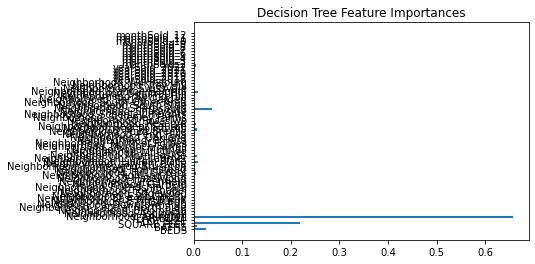

In [32]:
# decision tree test

pred_test_dtr= model_dtr.best_estimator_.predict(X_test)

plt.title('Decision Tree Feature Importances')
plt.barh(X_train.columns, model_dtr.best_estimator_.feature_importances_)
plt.show()

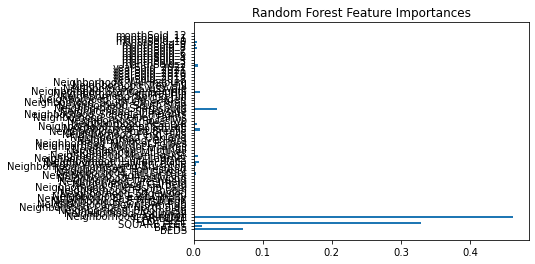

In [33]:
# random forrest test

pred_test_rfr= model_rfr.best_estimator_.predict(X_test)

plt.title('Random Forest Feature Importances')
plt.barh(X_train.columns, model_rfr.best_estimator_.feature_importances_)
plt.show()

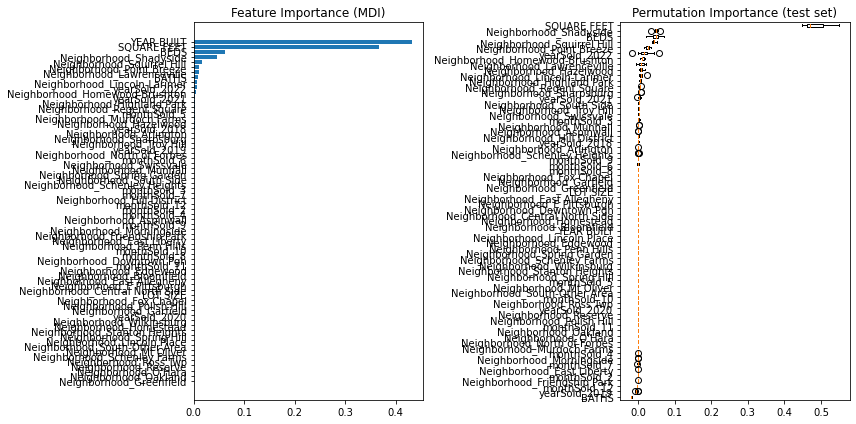

In [34]:
# gradient boosting regressor test

pred_test_gbr= model_gbr.best_estimator_.predict(X_test)

# get feature importance 
# source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
feature_importance = model_gbr.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    model_gbr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [35]:
# MLP test

pred_test_MLP = model_MLP.best_estimator_.predict(X_test)

In [36]:
# SDG test

pred_test_SGD = model_SGD.best_estimator_.predict(X_test)

In [37]:
# KRR test

pred_test_KRR = model_KRR.best_estimator_.predict(X_test)

In [38]:
# EN test

pred_test_EN = model_EN.best_estimator_.predict(X_test)

In [39]:
# BR test

pred_test_BR = model_BR.best_estimator_.predict(X_test)

In [40]:
# function that computes the error metrics 

def computeMetricsForRegression(model_name, model_name_string,test_type, y_type): 
    
    RMSE = int(np.sqrt(mean_squared_error(y_type,model_name)))
    MAE = int(mean_absolute_error(y_type,model_name))
    R2 = r2_score(y_type, model_name)
    
    print('\n',model_name_string,' results ', test_type, '\n')
    print("RMSE: ", f"{RMSE:,}")
    print("MAE:  ", f"{MAE:,}")
    print("R^2:  ", f"{R2:,.2f}")
    print()
    
    # source: https://www.datacourses.com/evaluation-of-regression-models-in-scikit-learn-846/
    fig, ax = plt.subplots()
    ax.scatter(model_name, y_type, edgecolors=(0, 0, 1))
#     ax.plot([y_type.min(), y_type.max()], [y_type.min(), y_type.max()], 'r--', lw=3)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.ticklabel_format(style='plain')
    plt.show()


 Lasso  results  training 

RMSE:  163,762
MAE:   103,899
R^2:   0.68



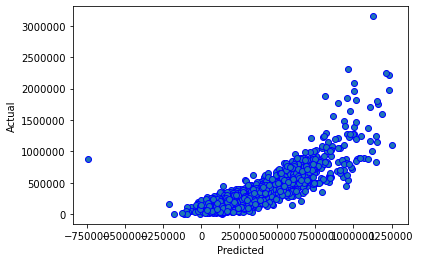


 Lasso  results  testing 

RMSE:  184,278
MAE:   124,803
R^2:   0.53



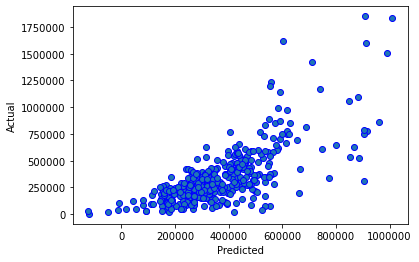

In [41]:
# compare lasso

computeMetricsForRegression(pred_train_lasso, 'Lasso', 'training', y_train)
computeMetricsForRegression(pred_test_lasso, 'Lasso', 'testing', y_test)


 Ridge  results  training 

RMSE:  163,710
MAE:   103,739
R^2:   0.68



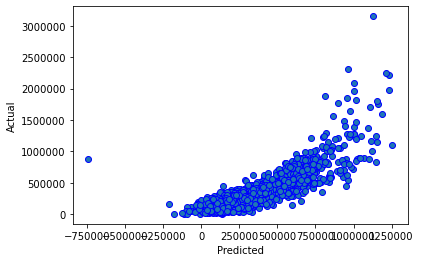


 Ridge  results  testing 

RMSE:  184,436
MAE:   124,905
R^2:   0.52



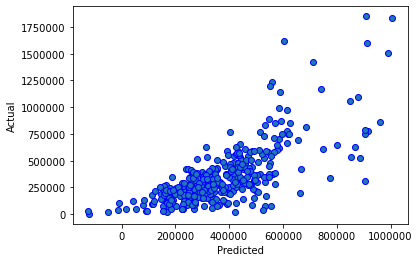

In [42]:
# compare ridge

computeMetricsForRegression(pred_train_ridge, 'Ridge', 'training', y_train)
computeMetricsForRegression(pred_test_ridge, 'Ridge', 'testing', y_test)


 Decision Tree  results  training 

RMSE:  132,467
MAE:   87,946
R^2:   0.79



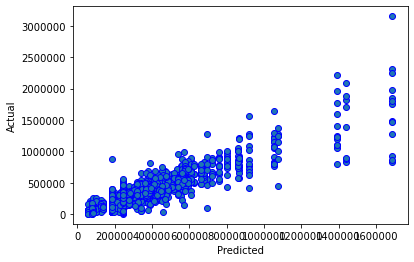


 Decision Tree  results  testing 

RMSE:  250,051
MAE:   151,443
R^2:   0.13



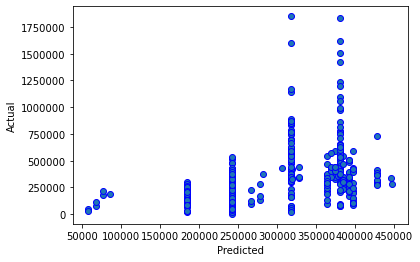

In [43]:
# compare decision tree

computeMetricsForRegression(pred_train_dtr, 'Decision Tree', 'training', y_train)
computeMetricsForRegression(pred_test_dtr, 'Decision Tree', 'testing', y_test)


 Random Forest  results  training 

RMSE:  90,271
MAE:   70,540
R^2:   0.90



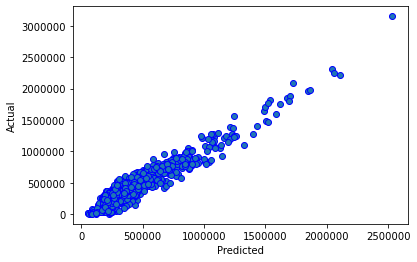


 Random Forest  results  testing 

RMSE:  201,327
MAE:   126,875
R^2:   0.43



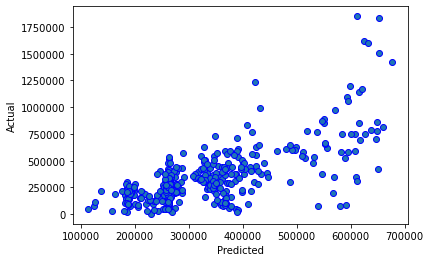

In [44]:
# compare random forest

computeMetricsForRegression(pred_train_rfr, 'Random Forest', 'training', y_train)
computeMetricsForRegression(pred_test_rfr, 'Random Forest', 'testing', y_test)


 Gradient Boosting  results  training 

RMSE:  102,878
MAE:   77,600
R^2:   0.87



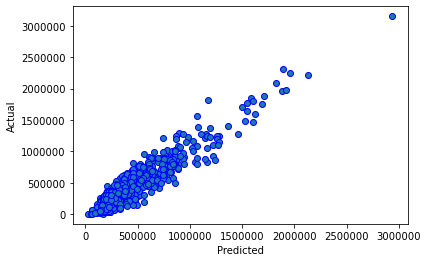


 Gradient Boosting  results  testing 

RMSE:  178,887
MAE:   115,437
R^2:   0.55



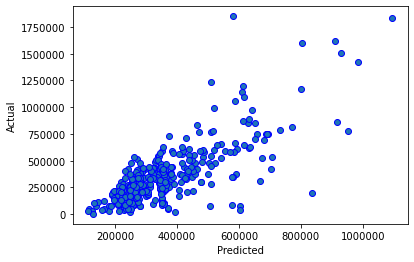

In [45]:
# compare gradient boosting 

computeMetricsForRegression(pred_train_gbr, 'Gradient Boosting', 'training', y_train)
computeMetricsForRegression(pred_test_gbr, 'Gradient Boosting', 'testing', y_test)


 Multi Layer Peceptron  results  training 

RMSE:  171,659
MAE:   110,269
R^2:   0.64



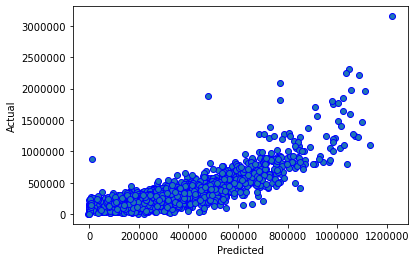


 Multi Layer Peceptron  results  testing 

RMSE:  185,902
MAE:   118,822
R^2:   0.52



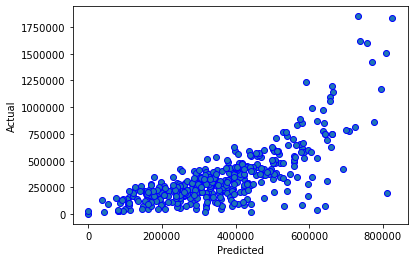

In [46]:
# compare MLP 

computeMetricsForRegression(pred_train_MLP, 'Multi Layer Peceptron', 'training', y_train)
computeMetricsForRegression(pred_test_MLP, 'Multi Layer Peceptron', 'testing', y_test)


 SGD Regression  results  training 

RMSE:  168,359
MAE:   107,535
R^2:   0.66



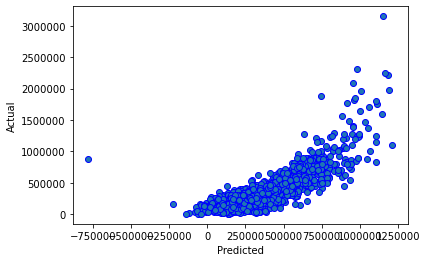


 SGD Regression  results  testing 

RMSE:  187,920
MAE:   128,384
R^2:   0.51



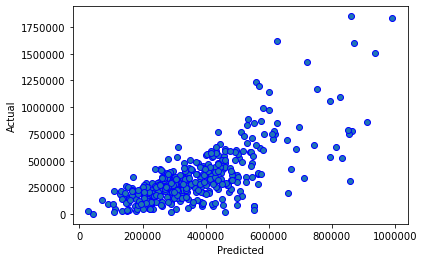

In [47]:
# compare SDG

computeMetricsForRegression(pred_train_SGD, 'SGD Regression', 'training', y_train)
computeMetricsForRegression(pred_test_SGD, 'SGD Regression', 'testing', y_test)


 KR Regression  results  training 

RMSE:  101,304
MAE:   69,565
R^2:   0.88



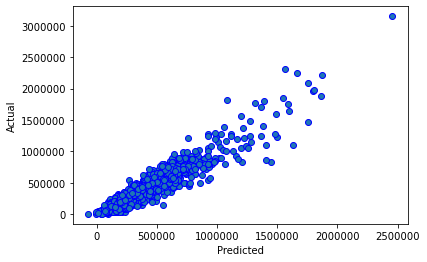


 KR Regression  results  testing 

RMSE:  192,351
MAE:   118,481
R^2:   0.48



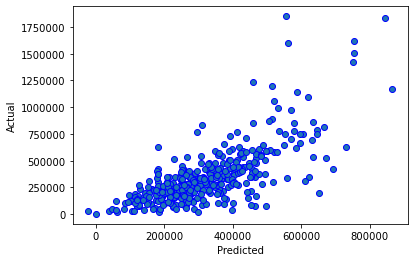

In [48]:
# compare Kernel Ridge

computeMetricsForRegression(pred_train_KRR, 'KR Regression', 'training', y_train)
computeMetricsForRegression(pred_test_KRR, 'KR Regression', 'testing', y_test)


 Elastic Net Regression  results  training 

RMSE:  163,708
MAE:   103,730
R^2:   0.68



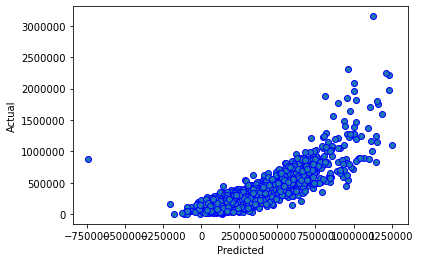


 Elastic Net Regression  results  testing 

RMSE:  184,476
MAE:   124,940
R^2:   0.52



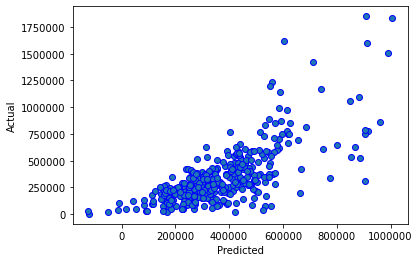

In [49]:
# compare EN

computeMetricsForRegression(pred_train_EN, 'Elastic Net Regression', 'training', y_train)
computeMetricsForRegression(pred_test_EN, 'Elastic Net Regression', 'testing', y_test)


 BayesianRidge Regression  results  training 

RMSE:  164,731
MAE:   104,589
R^2:   0.67



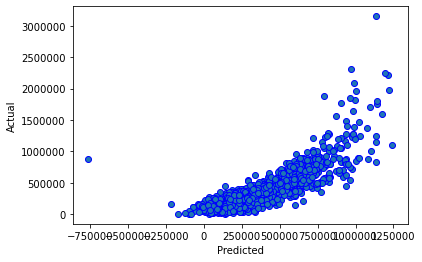


 BayesianRidge Regression  results  testing 

RMSE:  184,452
MAE:   124,889
R^2:   0.52



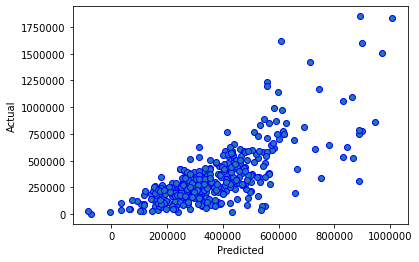

In [50]:
# compare BayesianRidge

computeMetricsForRegression(pred_train_BR, 'BayesianRidge Regression', 'training', y_train)
computeMetricsForRegression(pred_test_BR, 'BayesianRidge Regression', 'testing', y_test)


 Gradient Boosting Regression  results  Test 

RMSE:  100,200
MAE:   73,266
R^2:   -0.02



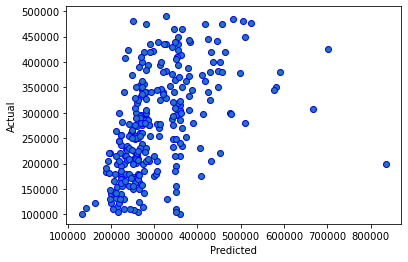

In [51]:
# limit results to feasible range

yHat = pd.DataFrame(pred_test_gbr, columns=['yHat'])

yActual = pd.DataFrame(y_test)
yActual.rename(columns={'PRICE':'yActual'}, inplace = True)

yHat.reset_index(inplace=True, drop=True)
yActual.reset_index(inplace=True, drop=True)

testResults = pd.concat([yHat, yActual], axis=1)

testResultsLimited = testResults.loc[(testResults['yActual'] > 100000) & (testResults['yActual'] < 500000)]

computeMetricsForRegression(testResultsLimited['yHat'], 'Gradient Boosting Regression','Test', testResultsLimited['yActual'])

In [52]:
# source: https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/plots/bar.html
import shap 

model = GradientBoostingRegressor(learning_rate=0.2, max_depth=3).fit(X_train, y_train)

# compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

C:\Users\CT\miniconda3\envs\aiclass\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


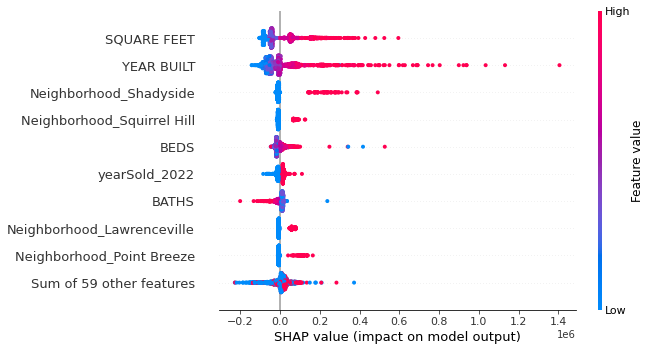

In [53]:
shap.plots.beeswarm(shap_values)